In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

In [2]:
import pynrc
from pynrc import nrc_utils

# Progress bar
from tqdm.auto import tqdm, trange

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Science         source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('HR 8799', 39.0, 30,  'F0V', 7430, -0.47, 4.35, 5.24, bp_k)]

# References     source,     sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('HD 220657', 'F8III', 5888, -0.01, 3.22, 3.04, bp_k)]

In [4]:
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[0]
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[0]

# For the purposes of simplicity, we will use pynrc.stellar_spectrum()
sp_sci = pynrc.stellar_spectrum(spt_sci, mag_sci, 'vegamag', bp_sci, 
                                Teff=Teff_sci, metallicity=feh_sci, log_g=logg_sci)
sp_sci.name = name_sci

# And the refernece source
sp_ref = pynrc.stellar_spectrum(spt_ref, mag_ref, 'vegamag', bp_ref, 
                                Teff=Teff_ref, metallicity=feh_ref, log_g=logg_ref)
sp_ref.name = name_ref

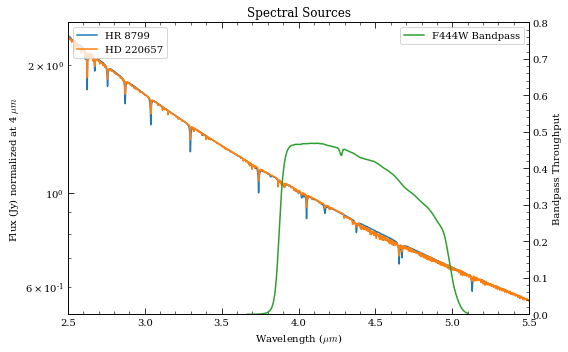

In [8]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    sp.convert('Jy')
    f = sp.flux / np.interp(4.0, w, sp.flux)
    ax.semilogy(w[ind], f[ind], lw=1.5, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized at 4 $\mu m$')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('Spectral Sources')

# Overplot Filter Bandpass
bp = pynrc.read_filter('F444W', 'CIRCLYOT', 'MASK430R')
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

In [114]:
# The initial call make take some time, as it will need to generate coefficients 
# to calculate PSF variations across wavelength, WFE drift, and mask location
filt, mask, pupil = ('F356W',  'MASK430R', 'CIRCLYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (65, 2)

obs = pynrc.NIRCam(filter=filt, image_mask=mask, pupil_mask=pupil,
                   wind_mode=wind_mode, xpix=subsize, ypix=subsize, 
                   fov_pix=fov_pix, oversample=oversample)

Single PSFs:   0%|          | 0/12 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/12 [00:00<?, ?it/s]

In [116]:
obs.update_detectors(read_mode='MEDIUM2', ngroup=2, nint=66, verbose=True)
_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)

New Ramp Settings
  read_mode  :  MEDIUM2
  nf         :        2
  nd2        :        8
  ngroup     :        2
  nint       :       66
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      320
  ypix       :      320
  x0         :      915
  y0         :     1501
New Ramp Times
  t_group    :   10.690
  t_frame    :    1.069
  t_int      :   12.828
  t_int_tot1 :   13.917
  t_int_tot2 :   13.917
  t_exp      :  846.680
  t_acq      :  918.551
Point Source Sensitivity (5-sigma): 20.29 vegamag
Surface Brightness Sensitivity (5-sigma): 21.33 vegamag/arcsec^2


In [129]:
sp = sp_sci
sp_bg = pynrc.stellar_spectrum('flat', 21, 'vegamag', obs.bandpass)

tbl = obs.ramp_optimize(sp_bg, sp_bright=sp, tacq_max=919, tacq_frac=0.05, ng_min=4, well_frac_max=0.9,
                        even_nints=True, nint_min=54, nint_max=58, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
BRIGHT2       7   54     14.97    808.19    867.00      3.2    0.052    0.109
BRIGHT2       7   55     14.97    823.16    883.05      3.3    0.052    0.109
BRIGHT2       7   56     14.97    838.13    899.11      3.3    0.052    0.109
BRIGHT2       7   57     14.97    853.09    915.16      3.3    0.052    0.109
BRIGHT2       7   58     14.97    868.06    931.22      3.3    0.052    0.109
BRIGHT1       8   54     16.04    865.92    924.73      2.9    0.056    0.096
BRIGHT1       8   55     16.04    881.96    941.85      3.0    0.056    0.096
BRIGHT1       8   56     16.04    897.99    958.98      3.0    0.056    0.096
BRIGHT1       7   58     13.90    806.06    869.22      2.5    0.048    0.085


In [137]:
obs.update_detectors(read_mode='SHALLOW4', ngroup=6, nint=30, verbose=True)
_ = obs.sensitivity(sp=sp, nsig=5, units='vegamag', verbose=True)

New Ramp Settings
  read_mode  : SHALLOW4
  nf         :        4
  nd2        :        1
  ngroup     :        6
  nint       :       30
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      320
  ypix       :      320
  x0         :      915
  y0         :     1501
New Ramp Times
  t_group    :    5.345
  t_frame    :    1.069
  t_int      :   31.002
  t_int_tot1 :   32.091
  t_int_tot2 :   32.091
  t_exp      :  930.065
  t_acq      :  962.734
Point Source Sensitivity (5-sigma): 21.21 vegamag
Surface Brightness Sensitivity (5-sigma): 22.23 vegamag/arcsec^2


In [77]:
obs.update_detectors(read_mode='SHALLOW4', ngroup=10, nint=34, verbose=True)
_ = obs.sensitivity(sp=sp, nsig=5, units='vegamag', verbose=True)

New Ramp Settings
  read_mode  : SHALLOW4
  nf         :        4
  nd2        :        1
  ngroup     :       10
  nint       :       34
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      320
  ypix       :      320
  x0         :      915
  y0         :     1501
New Ramp Times
  t_group    :    5.345
  t_frame    :    1.069
  t_int      :   52.383
  t_int_tot1 :   53.472
  t_int_tot2 :   53.472
  t_exp      : 1781.021
  t_acq      : 1818.045
Point Source Sensitivity (5-sigma): 21.22 vegamag
Surface Brightness Sensitivity (5-sigma): 22.50 vegamag/arcsec^2


In [48]:
obs.update_detectors(read_mode='DEEP8', ngroup=2, nint=1, verbose=True)
_ = obs.sensitivity(sp=sp, nsig=5, units='vegamag', verbose=True)

New Ramp Settings
  read_mode  :    DEEP8
  nf         :        8
  nd2        :       12
  ngroup     :        2
  nint       :        1
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      320
  ypix       :      320
  x0         :      915
  y0         :     1501
New Ramp Times
  t_group    :   21.381
  t_frame    :    1.069
  t_int      :   29.933
  t_int_tot1 :   31.022
  t_int_tot2 :    0.000
  t_exp      :   29.933
  t_acq      :   31.022
Point Source Sensitivity (5-sigma): 18.59 vegamag
Surface Brightness Sensitivity (5-sigma): 19.86 vegamag/arcsec^2


In [37]:
obs.update_detectors(read_mode='MEDIUM8', ngroup=2, nint=90, verbose=True)
_ = obs.sensitivity(sp=sp, nsig=5, units='vegamag', verbose=True)

New Ramp Settings
  read_mode  :  MEDIUM8
  nf         :        8
  nd2        :        2
  ngroup     :        2
  nint       :       90
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      320
  ypix       :      320
  x0         :      915
  y0         :     1501
New Ramp Times
  t_group    :   10.690
  t_frame    :    1.069
  t_int      :   19.243
  t_int_tot1 :   20.332
  t_int_tot2 :   20.332
  t_exp      : 1731.845
  t_acq      : 1829.851
Point Source Sensitivity (5-sigma): 20.41 vegamag
Surface Brightness Sensitivity (5-sigma): 21.70 vegamag/arcsec^2
